In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from keras.layers import LSTM, Dense, Dropout

In [3]:

# Load and pre-process the data


df = yf.download(tickers='BTC-usd', period='max', interval='1d')
df.dropna(inplace=True)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-01-16,20882.224609,21360.875000,20715.746094,21169.632812,21169.632812,26792494050
2023-01-17,21175.833984,21438.660156,20978.533203,21161.519531,21161.519531,24999983362
2023-01-18,21161.050781,21564.501953,20541.544922,20688.781250,20688.781250,30005625418


In [4]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df.shape

(3048, 6)

In [5]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]
print('train_size',train_size)
print('test_size', test_size)
print("train", train.shape)
print("test", test.shape)

train_size 2438
test_size 610
train (2438, 6)
test (610, 6)


In [6]:
# Convert the data into a 3D array (a sequence of sequences of timesteps)
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length - 1):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 3
X_train, y_train = create_sequences(train, sequence_length)
X_test, y_test = create_sequences(test, sequence_length)
print("X_train" , X_train.shape)
print("y_train", y_train.shape)
print ("x_test",X_test.shape)
print ("y_test",y_test.shape)

X_train (2434, 3, 6)
y_train (2434, 6)
x_test (606, 3, 6)
y_test (606, 6)


In [7]:
# Build and compile the model
#model = Sequential()
#model.add(LSTM(50, input_shape=(sequence_length, 6)))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
model = Sequential()
model.add(LSTM(100, input_shape=(sequence_length,X_train.shape[2]), return_sequences=True , activation= 'softmax'))
model.add(Dropout(0.2))
model.add(LSTM(100, activation= 'softmax'))
model.add(Dropout(0.2))
model.add(Dense(X_train.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 100)            42800     
                                                                 
 dropout (Dropout)           (None, 3, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 123,806
Trainable params: 123,806
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Reshape the input data for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],  X_test.shape[2]))
print("X_train", X_train.shape)
print("X_test", X_test.shape)

X_train (2434, 3, 6)
X_test (606, 3, 6)


In [9]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=250, validation_data=(X_test, y_test))

Epoch 1/250
77/77 [==============================] - 7s 26ms/step - loss: 0.0281 - val_loss: 0.1850
Epoch 2/250
77/77 [==============================] - 1s 16ms/step - loss: 0.0245 - val_loss: 0.1704
Epoch 3/250
77/77 [==============================] - 1s 14ms/step - loss: 0.0245 - val_loss: 0.1711
Epoch 4/250
77/77 [==============================] - 1s 15ms/step - loss: 0.0245 - val_loss: 0.1693
Epoch 5/250
77/77 [==============================] - 1s 16ms/step - loss: 0.0245 - val_loss: 0.1709
Epoch 6/250
77/77 [==============================] - 1s 16ms/step - loss: 0.0245 - val_loss: 0.1726
Epoch 7/250
77/77 [==============================] - 1s 16ms/step - loss: 0.0245 - val_loss: 0.1685
Epoch 8/250
77/77 [==============================] - 1s 16ms/step - loss: 0.0245 - val_loss: 0.1694
Epoch 9/250
77/77 [==============================] - 1s 15ms/step - loss: 0.0245 - val_loss: 0.1681
Epoch 10/250
77/77 [==============================] - 1s 17ms/step - loss: 0.0245 - val_loss: 0.1698

In [10]:
# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score:.4f}')


Test loss: 0.0016


In [11]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)

19/19 [==============================] - 1s 6ms/step


In [12]:

# Calculate mean absolute error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Calculate root mean squared error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Calculate mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))


In [13]:
# Calculate the metrics
mae_value = mae(y_test, y_pred)
rmse_value = rmse(y_test, y_pred)
mape_value = mape(y_test, y_pred)


# Print the metric values
print(f'MAE: {mae_value:.2f}')
print(f'RMSE: {rmse_value:.2f}')
print(f'MAPE: {mape_value:.2f}%')

MAE: 0.03
RMSE: 0.04
MAPE: 0.17%


In [14]:
# Make sure that the number of outputs of the model match the number of outputs in y_test
print('y_pred.shape[1]',y_pred.shape[1])
print('test.shape[1]',test.shape[1])
assert y_pred.shape[1] == y_test.shape[1]

y_pred.shape[1] 6
test.shape[1] 6


In [16]:
#evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAPE: {:.2f}%".format(mape))
print("RMSE: {:.2f}".format(rmse))
print("MSE: {:.2f}".format(mse))
print("MAE:{:.2f}".format(mae))

MAPE: 16.90%
RMSE: 0.04
MSE: 0.00
MAE:0.03


In [17]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

SMAPE1 = smape(y_test, y_pred)
print("smape: {:.2f}%".format(SMAPE1))

smape: 12.00%


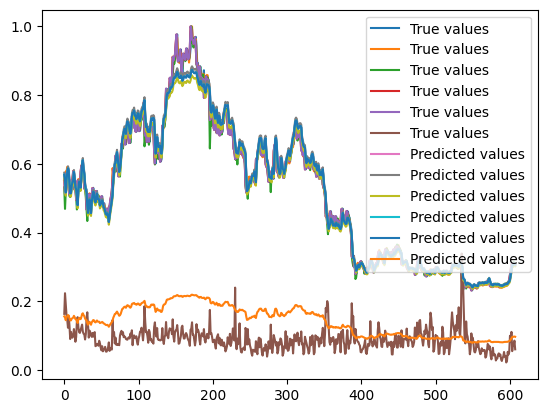

In [34]:
import matplotlib.pyplot as plt

# Plot the true values and predicted values
plt.plot(y_test, label='True values')
plt.plot(y_pred, label='Predicted values')

# Add a legend and show the plot
plt.legend()
plt.show()

In [19]:
y_pred = scaler.inverse_transform(y_pred)
y_pred

ValueError: non-broadcastable output operand with shape (608,1) doesn't match the broadcast shape (608,6)